In [1]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("../secrets/spatial-interaction-project-b528921f271f.json")

In [2]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

import cenpy
import imageio

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census ACS 2018 WMS

In [3]:
metros = pd.read_csv("../data/metrolist_one.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

In [4]:
bay = metros[(metros.metro_name.str.contains('San Jose')) | (metros.metro_name.str.contains('San Francisco'))]
bay = bay[bay.county_name!="San Benito, CA"]

bay.head()

,metro_fips,metro_name,county_fips,county_name
963,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6001,"Alameda, CA"
964,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6013,"Contra Costa, CA"
965,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6041,"Marin, CA"
966,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6075,"San Francisco, CA"
967,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6081,"San Mateo, CA"


In [88]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

def get_edges(fips, dataset, cbgs):
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("dataset", "STRING", dataset),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                SAFE_CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `spatial-interaction-project.safegraph.{dataset}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) IN {fips} AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})
    
    edges = edges[~edges['weight'].isnull()]

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

def get_graph(edges, nodes, method='direct'):
    if method == 'bundled':
        print('Bundling desire lines...')
        return hammer_bundle(nodes, edges,
                             source='focal', target='target',
                             decay=0.25,
                             x='X', y='Y')
    else:
        print('Linking desire lines...')
        return connect_edges(nodes, edges,
                             source='focal', target='target',
                             x='X', y='Y')

In [6]:
nodes = list()
shape = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

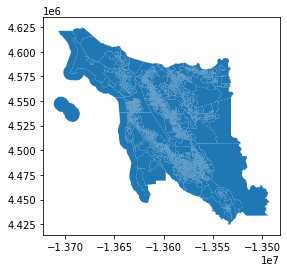

In [7]:
shape.plot()

In [8]:
water = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    year = 2018
    
    sfips = fips[:2]
    cfips = fips[2:]
    
    url = f"https://www2.census.gov/geo/tiger/TIGER{year}/AREAWATER/tl_{year}_{sfips}{cfips}_areawater.zip"
    
    water.append(gpd.read_file(url))

water = gpd.GeoDataFrame(pd.concat(water, ignore_index=True))

In [9]:
water = water.to_crs(3857)
water = water[water.geometry.area > 10**6]

<AxesSubplot:>

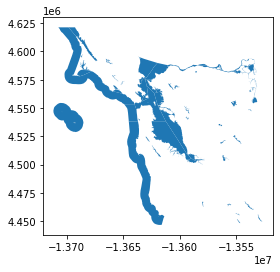

In [10]:
water.plot()

In [11]:
print(shape.shape)
print(nodes.shape)

(3978, 1)
(3978, 2)


In [12]:
fips_tuple = tuple(bay.county_fips.astype('str').str.pad(fillchar="0", side='left', width=5))

In [32]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years  = ["2019", "2020", "2021"]

full_range = np.concatenate([[ y + "_" + m for m in months] for y in years])

In [389]:
datasets = full_range[12:32]

In [390]:
print(datasets)

['2020_01' '2020_02' '2020_03' '2020_04' '2020_05' '2020_06' '2020_07'
 '2020_08' '2020_09' '2020_10' '2020_11' '2020_12' '2021_01' '2021_02'
 '2021_03' '2021_04' '2021_05' '2021_06' '2021_07' '2021_08']


In [89]:
%%time
edges = list()

for dataset in datasets:
        
        temp = get_edges(fips_tuple, dataset, nodes.index)
        temp['month'] = dataset
        
        edges.append(temp)

edges = pd.concat(edges, ignore_index=True)

CPU times: user 26.2 s, sys: 1.49 s, total: 27.7 s
Wall time: 2min 51s


In [401]:
edges.head()

,focal,target,weight,month,poi_county,home_county
0,60014226001,60014228001,747,2020_01,06001,06001
1,60014226001,60014228002,420,2020_01,06001,06001
2,60014226001,60014229002,304,2020_01,06001,06001
3,60014226001,60014227003,383,2020_01,06001,06001
4,60014226001,60014421002,25,2020_01,06001,06001


In [90]:
scico = pd.read_csv("https://raw.githubusercontent.com/asrenninger/palettes/master/scico_wide.csv")

In [122]:
def nodesplot(nodes):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.points(nodes,'X','Y',agg=None)
    spr = tf.spread(tf.shade(agg, cmap=list(scico.hawaii.array)[10]), px=8)
    
    return spr

def edgesplot(nodes, edges):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.line(edges, 'X','Y', agg=ds.count())
    spr = tf.shade(agg, cmap=list(scico.hawaii.array), how='eq_hist')
    
    return spr

def combiplot(nodes, edges):
    
    verts = nodesplot(nodes)
    links = edgesplot(nodes, edges)
    
    stack = tf.stack(verts, links)
    
    ready = tf.set_background(stack, '#000000')
    
    return ready.to_pil()

def plot_graphs_by_month(fig, data, nodes, dataset, x_range, y_range):
    
    temp = data[data['month']==dataset].drop('month', axis=1)
    
    graph = connect_edges(nodes, temp,
                          source='focal', target='target',
                          x='X', y='Y', weight='weight')

    img = combiplot(nodes, graph)

    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    ax.text(
        0.05,
        0.05,
        "Origin-Destination Flows",
        color="white",
        weight='bold',
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    year, month = re.split("_", dataset)
    
    months = ['January', 'February', 'March', 
              'April', 'May', 'June', 
              'July', 'August', 'September', 
              'October', 'November', 'December']
    
    ax.text(
        0.05,
        0.1,
        months[int(month)-1],
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    ax.text(
        0.05,
        0.3,
        year,
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    shape.plot(color='None', edgecolor='#ffffff', linewidth=0.25, alpha=0.5, ax=ax)
    
    network = nx.from_pandas_edgelist(temp, 'focal', 'target', ['weight'])
    
    density.append(nx.density(network))
    
    sub = plt.axes([0.05, 0.2, 0.25, 0.1], facecolor='#000000')
    sub.step(x=np.arange(1, len(density) + 1), y=density, color='#ffffff')
    
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#000000') 
    ax.spines['right'].set_color('000000')
    ax.spines['left'].set_color('000000')
    
    plt.title('network density', weight='bold', color='#ffffff', position=(0.2, 0)) 

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

CPU times: user 2min 12s, sys: 3.94 s, total: 2min 16s
Wall time: 1min 16s


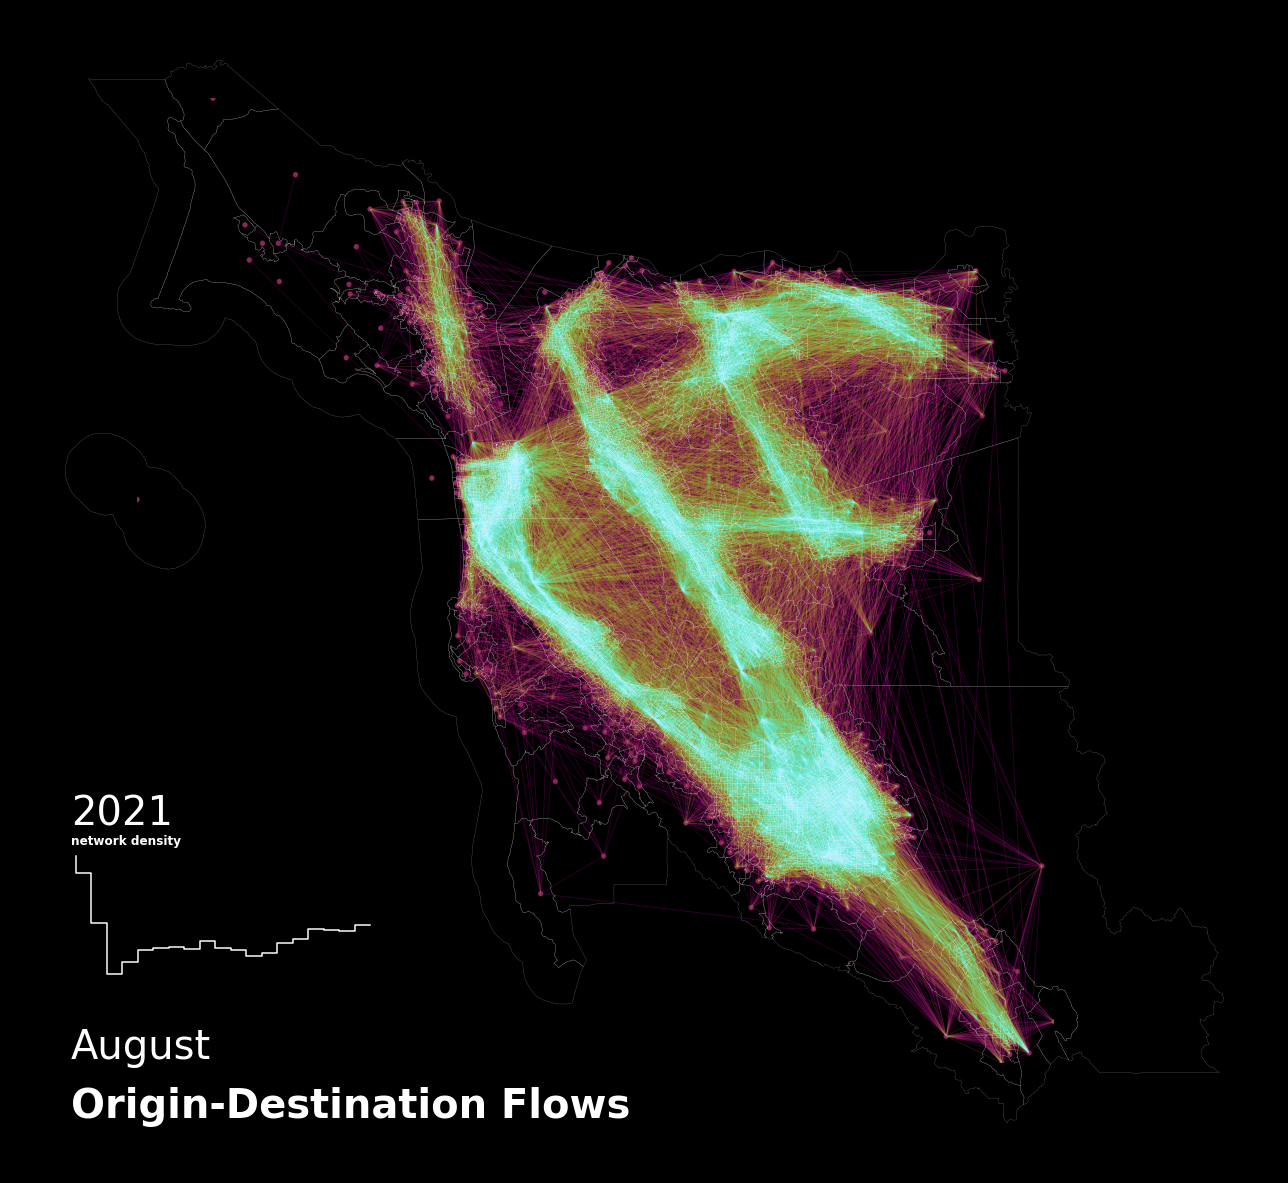

In [402]:
%%time
bnds = [(nodes['X'].min(), nodes['X'].max()), (nodes['Y'].min(), nodes['Y'].max())]

imgs = []
density = []

fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

for period in np.sort(edges.month.unique()):
    
    img = plot_graphs_by_month(fig, edges, nodes, period, x_range=bnds[0], y_range=bnds[1])
    imgs.append(img)

imageio.mimsave('bay_hawaii.gif', imgs, fps=1);

In [133]:
density = []

for period in np.sort(edges.month.unique()):
    
    temps = edges[edges['month']==period]
    graph = nx.from_pandas_edgelist(temps, 'focal', 'target', ['weight'])
    
    density.append(nx.density(graph))

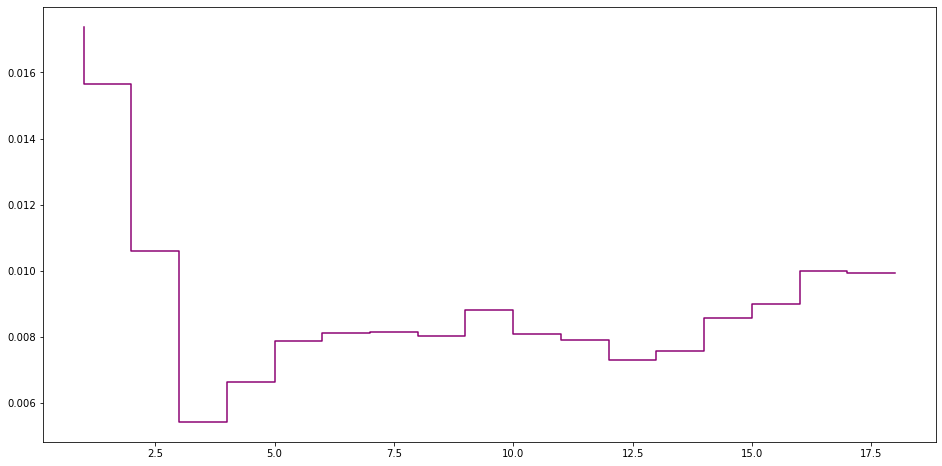

In [134]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.step(x=np.arange(1, len(density) + 1), y=density, color=scico.hawaii[0])

In [126]:
edges['poi_county'] = edges.target.astype('str').str.slice(stop=4).str.pad(fillchar="0", side='left', width=5)
edges['home_county'] = edges.focal.astype('str').str.slice(stop=4).str.pad(fillchar="0", side='left', width=5)

In [127]:
bay['county'] = bay.county_fips.astype('str').str.pad(fillchar="0", side='left', width=5)
bay['county_name'] = bay.county_name.str.replace(", CA", "")

merged = edges.merge(bay, left_on='poi_county', right_on='county', how='left')
merged = merged[merged['poi_county']==merged['home_county']]

In [130]:
names = merged.county_name.unique()

densities = list()

for name in names:
    
    density = []
    
    for period in np.sort(edges.month.unique()):
        
        temps = merged[(merged['county_name']==name) & (merged['month']==period)]
        graph = nx.from_pandas_edgelist(temps, 'focal', 'target', ['weight'])
    
        density.append(nx.density(graph))
        
    density = pd.DataFrame({'name': name,
                            'density': density})
    
    densities.append(density)
    
densities = pd.concat(densities, ignore_index=True)    

Text(0.5, 0.05, 'Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.')

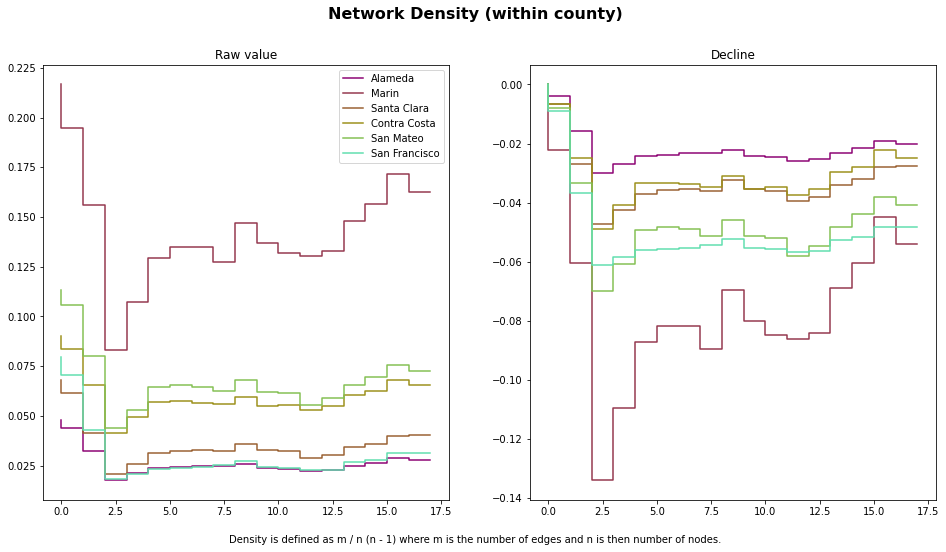

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

import random
pal = scico.hawaii[np.arange(0, scico.hawaii.shape[0], step = (scico.hawaii.shape[0] // bay.shape[0]))].to_numpy()

for i in np.arange(0, len(merged.county_name.unique())):
    
    labs = merged.county_name.unique()
    fips = labs[i]
    
    temp = densities[densities['name']==fips].reset_index()
    
    axs[0].set_title('Raw value')
    axs[0].step(x=temp.index, y=temp['density'], color=pal[i], label=labs[i])

for i in np.arange(0, len(merged.county_name.unique())):
    
    labs = merged.county_name.unique()
    fips = labs[i]
    
    temp = densities[densities['name']==fips].reset_index()
    
    axs[1].set_title('Decline')
    axs[1].step(x=temp.index, y=temp['density'] - temp['density'].max(), color=pal[i], label=labs[i])
    
axs[0].legend()

fig.suptitle('Network Density (within county)', fontsize=16, weight='bold')
fig.text(0.5, 0.05, "Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.", ha='center')

In [141]:
import leidenalg as la
import igraph as ig

<AxesSubplot:>

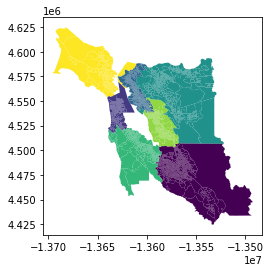

In [287]:
working = edges[edges.month=="2020_01"][['focal', 'target', 'weight']]
G = ig.Graph.TupleList(working.values, 
                       weights=True, directed=True)
partition = la.find_partition(G, la.ModularityVertexPartition)
membership = pd.DataFrame({'id': G.vs['name'], 'membership': partition._membership})
shape.merge(membership, left_on='cbg', right_on='id', how='left').plot('membership')

<AxesSubplot:>

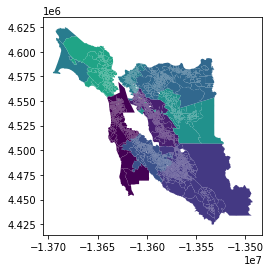

In [213]:
working = edges[edges.month=="2020_06"][['focal', 'target', 'weight']]
G = ig.Graph.TupleList(working.values, 
                       weights=True, directed=True)
partition = la.find_partition(G, la.ModularityVertexPartition)
membership = pd.DataFrame({'id': G.vs['name'], 'membership': partition._membership})
shape.merge(membership, left_on='cbg', right_on='id', how='left').plot('membership')

<AxesSubplot:>

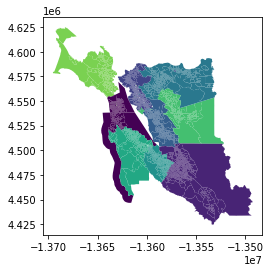

In [212]:
working = edges[edges.month=="2021_06"][['focal', 'target', 'weight']]
G = ig.Graph.TupleList(working.values, 
                       weights=True, directed=True)
partition = la.find_partition(G, la.ModularityVertexPartition)
membership = pd.DataFrame({'id': G.vs['name'], 'membership': partition._membership})
shape.merge(membership, left_on='cbg', right_on='id', how='left').plot('membership')

In [360]:
results = {}

for month in edges.month.unique():
    working = edges[edges.month==month][['focal', 'target', 'weight']]
    G = ig.Graph.TupleList(working.values, 
                           weights=True, directed=True)
    
    partition = la.find_partition(G, la.ModularityVertexPartition, weights=G.es['weight'])
    partition_agg = partition.aggregate_partition()
    infomap = ig.Graph.community_infomap(G, edge_weights=G.es['weight'])
    
    counts_la = pd.DataFrame({'id': G.vs['name'],
                              'membership': partition._membership}).groupby(['membership']).size()
    
    counts_im = pd.DataFrame({'id': G.vs['name'],
                              'membership': infomap._membership}).groupby(['membership']).size()
    
    results[month] = {'min_leiden': np.min(counts_la.values),
                      'max_leiden': np.max(counts_la.values),
                      'avg_leiden': np.mean(counts_la.values),
                      'partition_quality': partition_agg.quality(),
                      'min_infomap': np.min(counts_im.values),
                      'max_infomap': np.max(counts_im.values),
                      'avg_infomap': np.mean(counts_im.values)}

In [361]:
pd.DataFrame(results).T.reset_index()

,index,min_leiden,max_leiden,avg_leiden,partition_quality,min_infomap,max_infomap,avg_infomap
0,2020_01,53.0,747.0,396.900000,0.741042,1.0,123.0,18.290323
1,2020_02,1.0,749.0,330.750000,0.752015,1.0,114.0,18.721698
2,2020_03,53.0,770.0,330.083333,0.791114,1.0,89.0,13.072607
3,2020_04,1.0,718.0,122.343750,0.829888,1.0,136.0,7.767857
4,2020_05,1.0,739.0,177.909091,0.815798,1.0,96.0,8.775785
5,2020_06,1.0,758.0,230.823529,0.797283,1.0,75.0,9.146853
6,2020_07,1.0,748.0,244.687500,0.787772,1.0,118.0,9.642857
7,2020_08,1.0,730.0,245.812500,0.789032,1.0,105.0,9.881910
8,2020_09,1.0,762.0,231.705882,0.789961,1.0,99.0,10.257812
9,2020_10,1.0,879.0,302.923077,0.780209,1.0,87.0,11.000000


In [368]:
optimiser = la.Optimiser()
profile = optimiser.resolution_profile(G, la.CPMVertexPartition,
                                       resolution_range=(0,1))

686it [01:31,  7.48it/s, resolution_parameter=0.00102] 


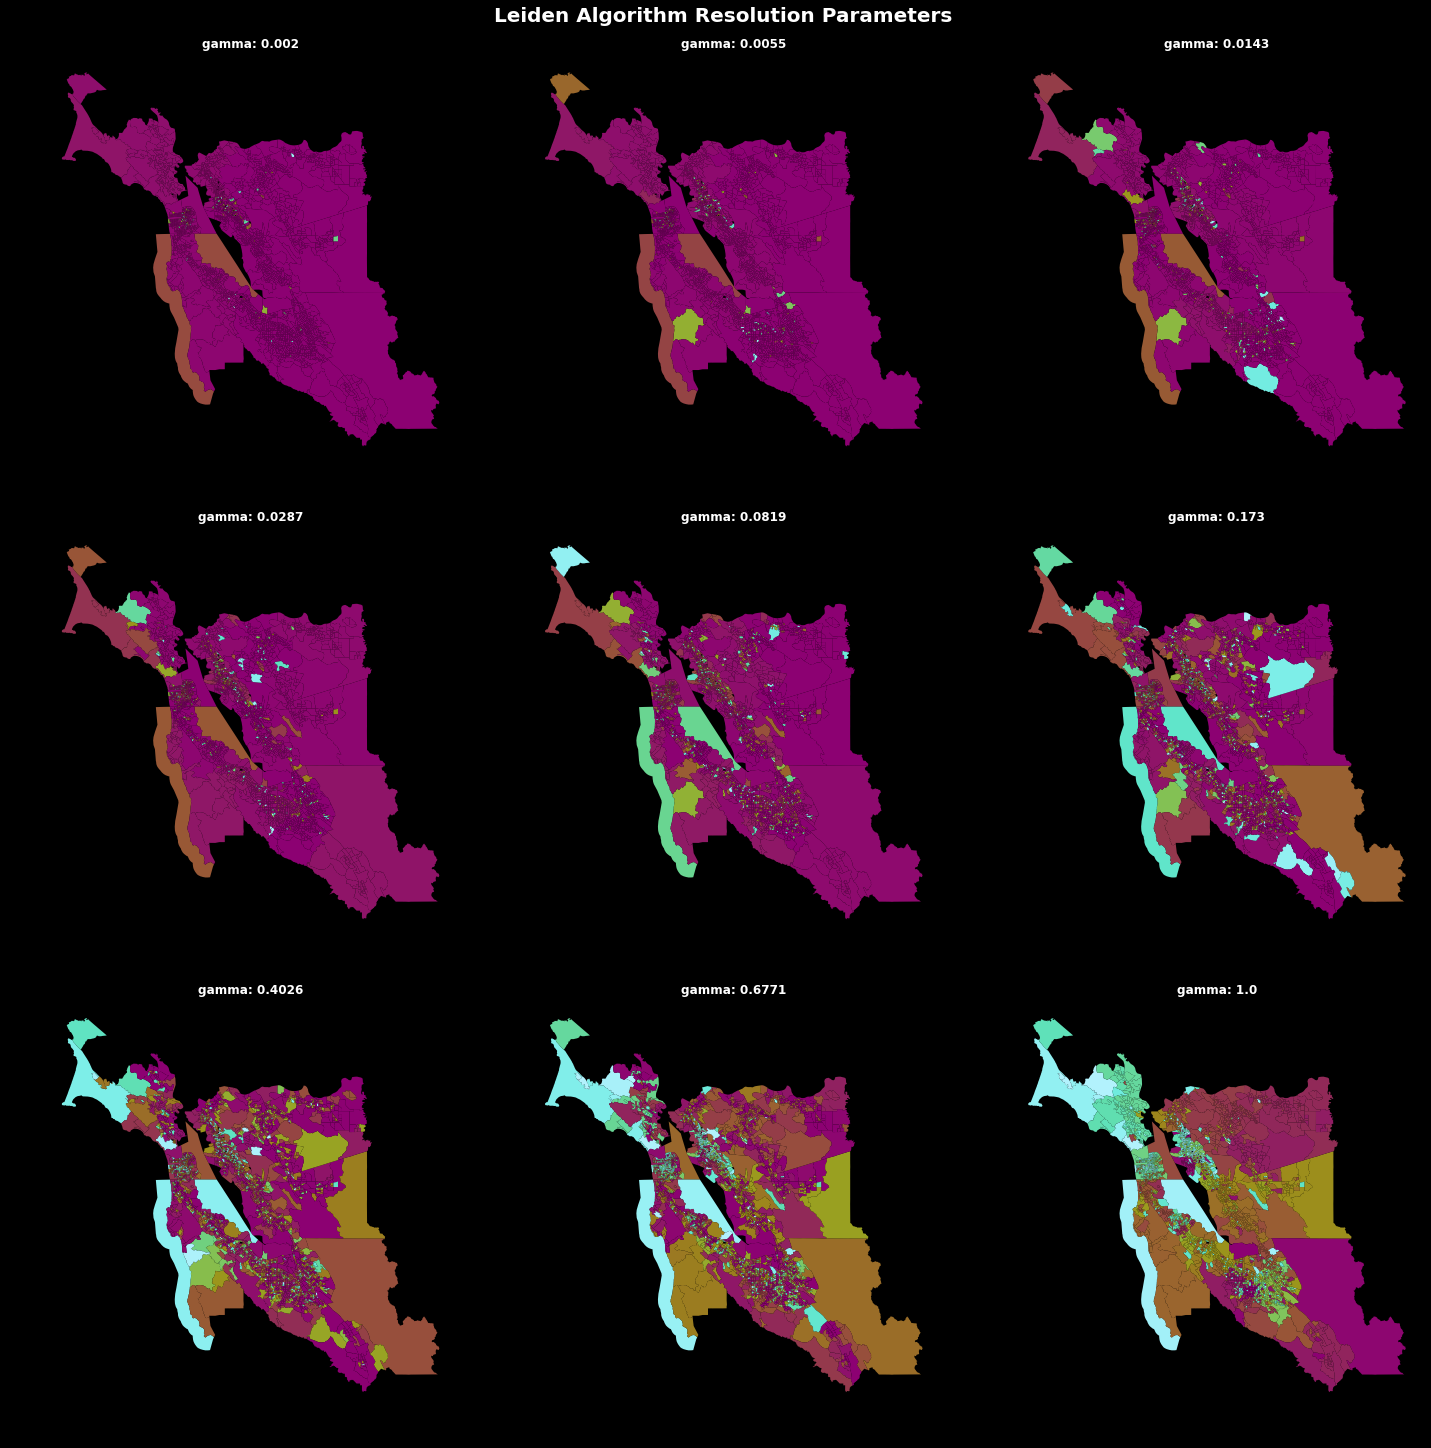

In [388]:
from matplotlib.colors import LinearSegmentedColormap

fig, axs = plt.subplots(3, 3, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

index = np.arange(7, len(profile) + 1, len(profile) // 9)

for i in np.arange(0, 9):
    
    cm = LinearSegmentedColormap.from_list('testing', scico.hawaii, N=profile[1]._len)
    
    membership = pd.DataFrame({'id': G.vs['name'], 'membership': profile[index[i]]._membership})
    shape.merge(membership, left_on='cbg', right_on='id', how='left').plot('membership', ax=axs[i],
                                                                           cmap=cm)
    axs[i].set_facecolor('k')
    axs[i].set_title(f"gamma: {round(profile[index[i]].resolution_parameter, 4)}", color='w', weight='bold')
        
fig.suptitle('Leiden Algorithm Resolution Parameters', color='w', size=20, weight='bold')
fig.savefig('leiden.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

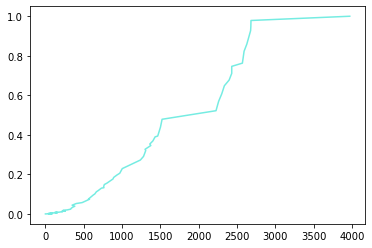

In [365]:
plt.plot([i._len for i in profile],[i.resolution_parameter for i in profile], c=scico.hawaii.iloc[90])